# Análise de Corvengência de Municípios
## Daniel N. Rocha e Rafael Kovashikawa
### Trabalho de Estatística – FGV EPGE
O objetivo deste estudo é realizar testes estatísticos com dados empíricos do IBGE para testar a hipótese de corvergência acerca da evolução do PIB dos municípios brasileiros. Isto é, testaremos se os municípios com economia menor de fato cresceram mais rapidamente do que os que possuiam atividade econômica mais intensa.

In [2]:
%%capture
%pip install xlrd
%pip install numpy
%pip install pandas
%pip install seaborn
%pip install palettable
%pip install matplotlib
%pip install jupyterthemes

In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import seaborn as sns
import palettable
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-r05p7bv8 because the default path (/config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import matplotlib.style
import matplotlib as mpl
mpl.rcParams['grid.color'] = 'white'
# mpl.rcParams['legend.labelcolor'] = 'white'
mpl.rcParams['axes.titlecolor'] = 'white'
mpl.rcParams['axes.labelcolor'] = 'white'
mpl.rcParams['xtick.color'] = 'white'
mpl.rcParams['ytick.color'] = 'white'
mpl.rcParams['axes.titlesize'] = '20.0'
mpl.rcParams['figure.figsize'] = '13.0, 8.0'
mpl.rcParams['legend.framealpha'] = '0.8'

## Importando os Dados:

In [31]:
pib_cities_02_09 = pd.read_excel('PIB dos Munic¡pios - base de dados 2002-2009.xls')
pib_cities_10_17 = pd.read_excel('PIB dos Munic¡pios - base de dados 2010-2017.xls')
pib_cities = pd.concat([pib_cities_02_09, pib_cities_10_17], ignore_index=True)

In [86]:
pib_cities = pib_cities[['Ano','Nome da Grande Região','Nome da Unidade da Federação','Nome do Município',
                         'Produto Interno Bruto per capita, \na preços correntes\n(R$ 1,00)',
                         'Valor adicionado bruto total, \na preços correntes\n(R$ 1.000)',
                         'Produto Interno Bruto, \na preços correntes\n(R$ 1.000)']]
pib_cities.rename(inplace=True, columns={'Produto Interno Bruto, \na preços correntes\n(R$ 1.000)':'PIB',
                              'Valor adicionado bruto total, \na preços correntes\n(R$ 1.000)':'Valor adicionado',
                              'Produto Interno Bruto per capita, \na preços correntes\n(R$ 1,00)':'PIB per capta',
                              'Nome da Grande Região':'Região','Nome da Unidade da Federação':'UF',
                              'Nome do Município':'Município'})
pib_cities.sort_values(['Município','Ano'],inplace=True,ignore_index=True)
pib_cities

,Ano,Região,UF,Município,PIB per capta,Valor adicionado,PIB
0,2002,Centro-oeste,Goiás,Abadia de Goiás,3552.65,18196.128,19813.138
1,2003,Centro-oeste,Goiás,Abadia de Goiás,3915.65,21263.259,22773.416
2,2004,Centro-oeste,Goiás,Abadia de Goiás,3924.03,22441.792,23756.057
3,2005,Centro-oeste,Goiás,Abadia de Goiás,4473.47,26567.432,28156.001
4,2006,Centro-oeste,Goiás,Abadia de Goiás,4771.80,29378.047,31164.647
...,...,...,...,...,...,...,...
89041,2013,Sudeste,São Paulo,Óleo,22610.72,60428.099,60506.294
89042,2014,Sudeste,São Paulo,Óleo,29120.06,77075.864,77226.408
89043,2015,Sudeste,São Paulo,Óleo,31658.75,82658.788,83199.184
89044,2016,Sudeste,São Paulo,Óleo,34502.38,89060.644,89878.689


## Visualizando para uma cidade:

,Ano,Região,UF,Município,PIB per capta,Valor adicionado,PIB
51720,2003,2003,2003,Niterói,0.093008,0.105249,0.099177
51721,2004,2004,2004,Niterói,0.178640,0.165016,0.185253
51722,2005,2005,2005,Niterói,0.020604,0.019527,0.026326
51723,2006,2006,2006,Niterói,0.076363,0.081786,0.082319
51724,2007,2007,2007,Niterói,0.162355,0.146465,0.155852
51725,2008,2008,2008,Niterói,0.056865,0.062084,0.065583
51726,2009,2009,2009,Niterói,0.125031,0.127664,0.128496
51727,2010,2010,2010,Niterói,0.128106,0.142791,0.146798
51728,2011,2011,2011,Niterói,0.213157,0.228168,0.219114
51729,2012,2012,2012,Niterói,0.148483,0.149821,0.153377


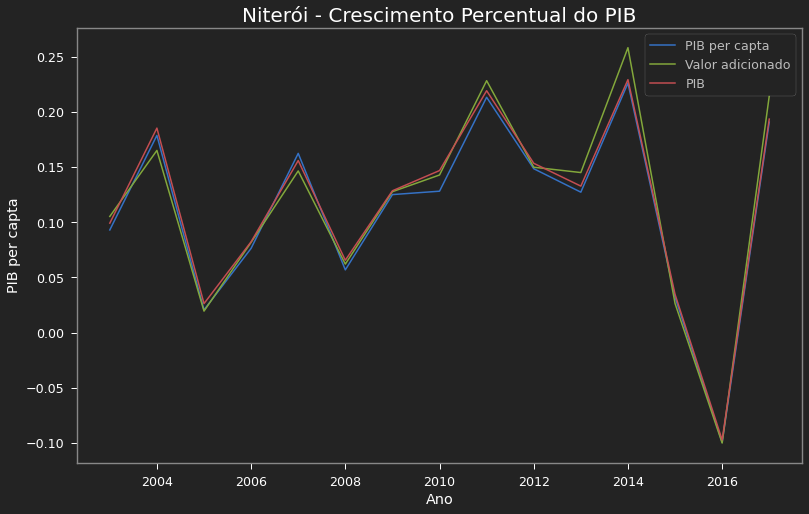

In [150]:
city=pib_cities[pib_cities['Município']=='Niterói'][['PIB per capta','Valor adicionado','PIB']].pct_change().dropna()
city.insert(0,'Ano',pib_cities[pib_cities['Município']=='Niterói']['Ano'])
city.insert(1,'Região',pib_cities[pib_cities['Município']=='Niterói']['Ano'])
city.insert(2,'UF',pib_cities[pib_cities['Município']=='Niterói']['Ano'])
city.insert(3,'Município','Niterói')
sns.lineplot(data=city,x='Ano',y='PIB per capta',label='PIB per capta')
sns.lineplot(data=city,x='Ano',y='Valor adicionado',label='Valor adicionado')
sns.lineplot(data=city,x='Ano',y='PIB',label='PIB')
plt.title('Niterói'+' - Crescimento Percentual do PIB')
city

## Iterando para todas as cidades:

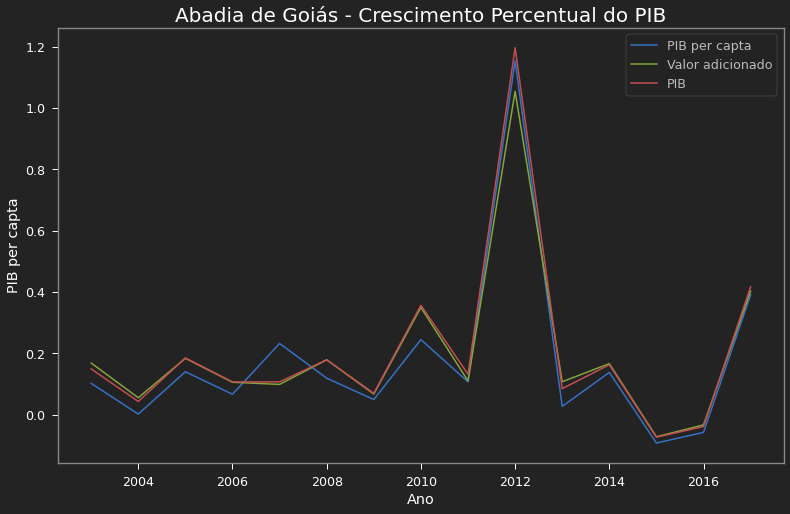

In [149]:
for c in pib_cities['Município']:
    city = pib_cities[pib_cities['Município']==c][['PIB per capta','Valor adicionado','PIB']].pct_change().dropna()
    city.insert(0,'Ano',pib_cities[pib_cities['Município']==c]['Ano'])
    city.insert(1,'Região',pib_cities[pib_cities['Município']==c]['Ano'])
    city.insert(2,'UF',pib_cities[pib_cities['Município']==c]['Ano'])
    city.insert(3,'Município',c)
    sns.lineplot(data=city,x='Ano',y='PIB per capta',label='PIB per capta')
    sns.lineplot(data=city,x='Ano',y='Valor adicionado',label='Valor adicionado')
    sns.lineplot(data=city,x='Ano',y='PIB',label='PIB')
    plt.title(c+' - Crescimento Percentual do PIB')
    plt.legend()
    break